In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from mae_visualize_utils import *
from mae_visualize import *
from util.datasets import *
from util.pos_embed import *
from models_mae import *

from torch.utils.data import Subset


# Data Load
Load the UCI-HAR[[1]](#1) dataset 

<a id="1">[1]</a> 
Reyes-Ortiz, J., Anguita, D., Ghio, A., Oneto, L., & Parra, X. (2013). Human Activity Recognition Using Smartphones [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C54S4K.

In [3]:
patch_size = [1, 20]
normalization=False
data_path = "data/200"
test_data = True
data = "UCIHAR"
transform=False
alt=True

# load data
dataset, labels, activity_labels, ids, times = load_dataset(data_path=data_path, data=data, test_data=test_data, alt=alt,
                                                             normalization=normalization, transform=transform)

patch_num = None
patch_size1, patch_size2 = patch_size

input_size = [dataset[0][0].shape[1], dataset[0][0].shape[2]]

if int(input_size[1]/patch_size2) !=patch_num:
    patch_num = int(input_size[1]/patch_size2)


in_chans = dataset[0][0].shape[0]


print(f"input_size: {input_size}, patch_size:{patch_size}, patch_num: {patch_num}")
print(dataset.shape)

False
input_size: [6, 200], patch_size:[1, 20], patch_num: 10
[torch.Size([793, 1, 6, 200]), torch.Size([793])]


# Reconstruction

Model Load

In [ ]:
# load pre_trained model

checkpoint_path = "checkpoint-19.pth" #specify path to your checkpoint
model_mae = load_model_pretrain(checkpoint_path=checkpoint_path, input_size=input_size, patch_size=patch_size, finetune_interpolate_patches=False,
                                alt=True, in_chans=in_chans)

decoder_pos_embed shape BEFORE loading into model: torch.Size([1, 61, 512])
model expected shape: torch.Size([1, 61, 512])


Select `n_inputs` number of inputs consecutively starting from the `m`th input. The grey vertical lines denote each time window input. True activity labels per input is displayed in the second line of the plot title.

test loss= 0.025(MSE), 0.121(nMSE)
torch.Size([1, 1, 3600, 3]) torch.Size([1, 1, 3600, 3]) torch.Size([1, 1, 3600, 3]) torch.Size([1, 1, 3600, 3])


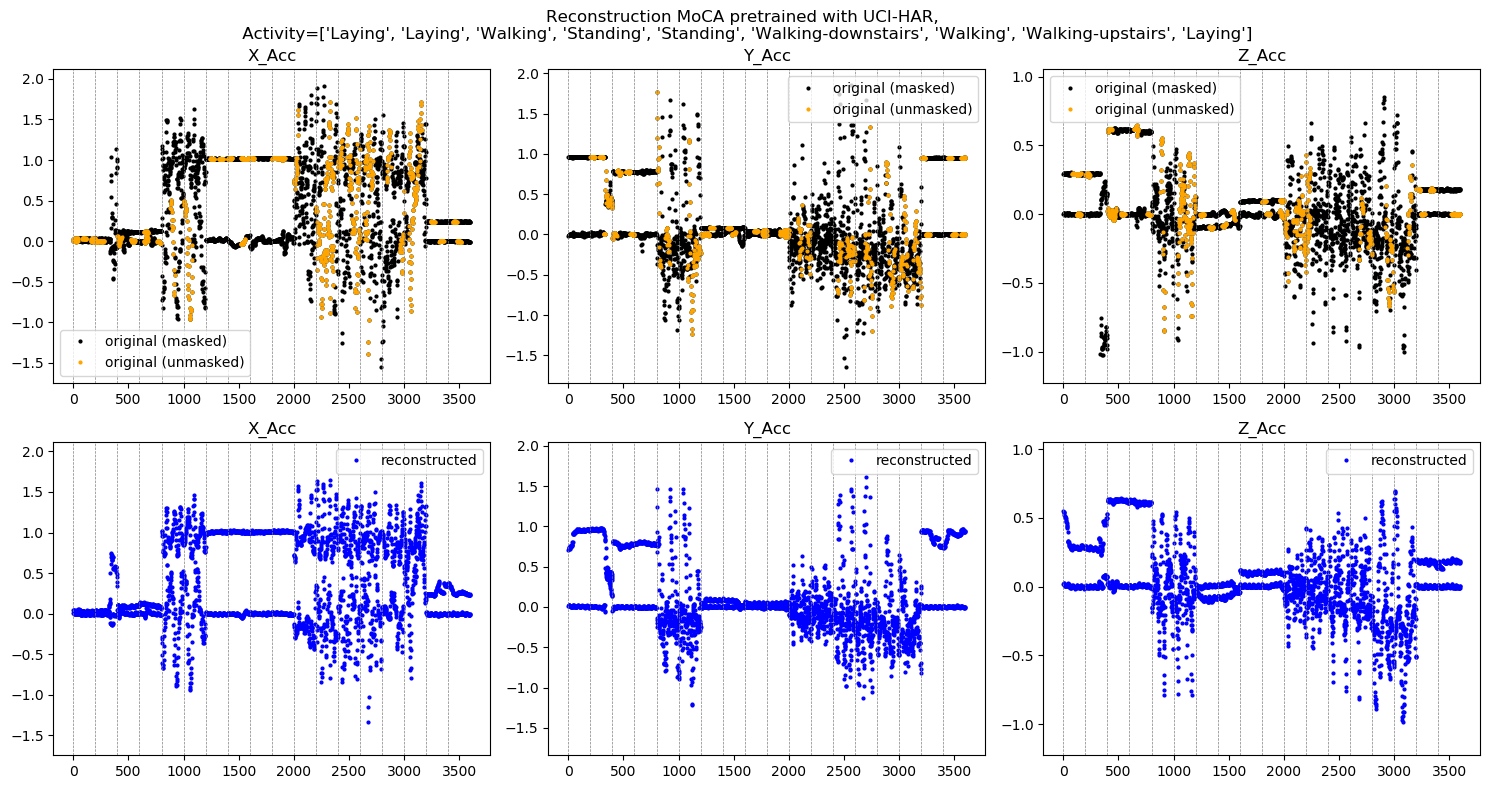

In [5]:
m=250
n_inputs = 9

x = dataset.X[m:m+n_inputs]
labels = dataset.y[m:m+n_inputs]


title = "MoCA pretrained with UCI-HAR"
plot_reconstruction(model=model_mae, x=x, input_length=input_size[1], alt=True, mask_ratio=0.75, norm_pix_loss=False,
                    title = title, marg = 0.2, linestyle="",
                    activity_label=activity_labels, labels=labels, import_mask=None, seed=None, figsize=(15,8))

# Classification

Loading the finetune model checkpoint

In [ ]:
FT_checkpoint_path = "MoCAwAug_FT_checkpoint-49.pth"

FT_model = load_model_ft(checkpoint_path=FT_checkpoint_path,
                         LP=False, nb_classes=7, in_chans=in_chans, input_size=input_size, patch_size=patch_size,
                         finetune_interpolate_patches=False, mask_finetune=0, device='cpu')

<All keys matched successfully>


Select `n_inputs` number of inputs consecutively starting from the `m`th input.

In [7]:
m=250
n_inputs = 100

data_subset = Subset(dataset, list(range(m, m + n_inputs)))
preds, targets, acc = mae_classification_pass(dataset=data_subset, model=FT_model, batch_size=20, device='cpu', num_workers=0)

Plot the confusion matrix for the `n_inputs` number of inputs

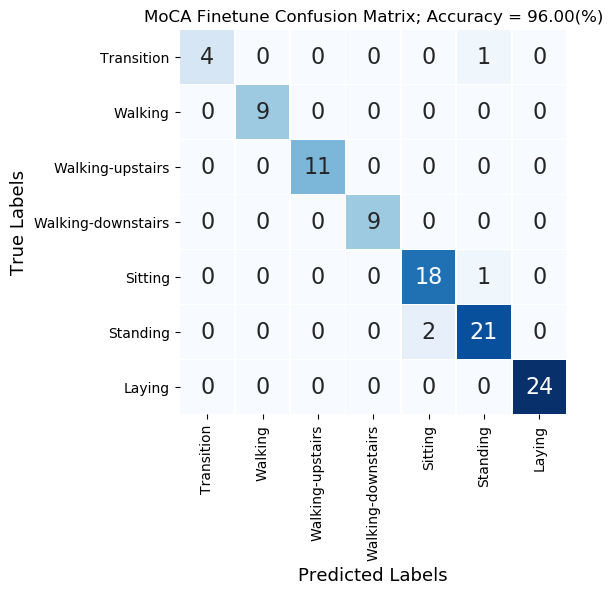

In [8]:
# plot the confusion matrix
cm_test = confusion_matrix(targets, preds)

plt.figure(figsize=(5, 5))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', xticklabels=activity_labels.values(),
            yticklabels=activity_labels.values(), cbar=False, linewidth=.5, annot_kws={"fontsize":16})
plt.xlabel('Predicted Labels', fontsize=13)
plt.ylabel('True Labels', fontsize=13)
plt.title(f'MoCA Finetune Confusion Matrix; Accuracy = {acc:.2f}(%)')
plt.show()

Alternatively, run the following bash command with arguments to produce classification confusion matrix for the entire test set:

In [ ]:
!python submitit_finetune.py --eval --confusion_matrix \
  --wk_dir {working_directory} --job_name {job_name} \
    --data_path {UCIHAR_data_path} --data "UCIHAR" \
    --nodes 1 --batch_size 500 --epochs 20  \
    --cls_token --patch_size1 1 --patch_size2 20 --alt \
    --model vit_base_patch16 --nb_classes 7 \
    --plot_save_name {plot_save_name} --plot_title {plot_title} \
    --resume {FT/LP_checkpoint}